# Playing with the ACTS dataset

This notebook continues the work in ActsExample1. I add here some useful code for fetching and cleaning the ACTS data, and then I demonstrate how to bin it into 3D images.

In [2]:
# System
from __future__ import print_function
import os

# Externals
import numpy as np
import matplotlib.pyplot as plt

# Locals
from drawing import draw_3d_event

# Magic
%matplotlib notebook
import tensorflow as tf

In [3]:
np.set_printoptions(precision=3)

## Utilities

In [4]:
def calc_eta(theta):
    """Calculates eta from a theta value or flat array"""
    return -1. * np.log(np.tan(theta / 2.))

def calc_phi(rphi, r):
    """Calculates phi from rphi"""
    return rphi / r
# I vectorize it to work on an array of arrays
calc_phi = np.vectorize(calc_phi, otypes='O')

def filter_samples(idx, *arrays):
    """Apply a filter index to a list of arrays"""
    return map(lambda x: x[idx], arrays)

def filter_objects(idx, *arrays):
    """
    Apply array of filter indices to some object arrays.
    Each input array should be an array of arrays (dtype='O').
    """
    filt_func = np.vectorize(lambda x: x[idx], otypes='O')
    return map(lambda a: np.stack(filt_func(a)), arrays)

In [5]:
class ActsData():
    """Empty class for setting variables as attributes"""
    pass

def load_data(filename):
    """
    Retrieve data from one file
    Returns a data object with attributes for each numpy array
    """
    d = ActsData()
    f = np.load(filename, encoding='bytes')
    # Track level truth quantities
    d.true_theta = f['truth_Theta']
    d.true_eta = calc_eta(d.true_theta)
    d.true_phi = f['truth_Phi']
    d.true_qop = f['truth_QoverP']
    d.true_pt = np.abs(1/d.true_qop)
    # Detector hit measurements
    d.nstep = f['Filter_nSteps']
    d.rphi = f['Meas_RPHI']
    d.z = f['Meas_z']
    d.r = f['Cyl_R']
    d.phi = calc_phi(d.rphi, d.r)
    return d

def clean_data(data, fix_phi=False):
    """
    Cleans up the data, selecting barrel tracks and good hits.
    """
    barrel_tracks = np.abs(data.true_eta) < 1
    d = ActsData()

    # filter out all tracks not perfectly in the barrel.
    d.true_theta, d.true_eta, d.true_phi, d.true_qop, d.true_pt = (
        filter_samples(barrel_tracks, data.true_theta, data.true_eta,
                       data.true_phi, data.true_qop, data.true_pt))
    d.nstep, d.rphi, d.z, d.r, d.phi = (
        filter_samples(barrel_tracks, data.nstep, data.rphi,
                       data.z, data.r, data.phi))

    # To select the actual layer hits, I select the indices of the steps
    # I want. I'm currently taking the middle of each detector layer triplet,
    # and ignoring all of the apparent "auxiliary" steps. This assumes
    # all tracks have the fixed 31 steps as previously discovered, so it's
    # a bit fragile and will need to be updated if the data changes.
    assert np.all(d.nstep == 31)
    #good_hit_idxs = np.array([1, 4, 9, 11, 14, 17, 20, 24, 27])
    good_hit_idxs = np.array([2, 5, 8, 11, 15, 18, 21, 25, 28])
    d.rphi, d.z, d.r, d.phi = filter_objects(
        good_hit_idxs, d.rphi, d.z, d.r, d.phi)
    
    # Current data has some funny artifacts in phi.
    # Here is a shitty, hacky correction. Needs to be fixed upstream.
    if fix_phi:
        for i in range(d.phi.shape[1]):
            phi = d.phi[:,i]
            phi = phi * np.pi * 2 / (phi.max() - phi.min())
            d.phi[:,i] = phi - phi.min() - np.pi

    # Calculate theta
    d.theta = np.arctan(d.r / d.z)
    # Fix negative values so theta ranges from (0, pi)
    negidx = d.theta < 0
    d.theta[negidx] = d.theta[negidx] + np.pi
    d.eta = calc_eta(d.theta)

    return d

## Load the data

In [6]:
input_file = '/Users/mudigonda/Data/KFTest_all.npy'

In [7]:
# Load the raw data
raw_data = load_data(input_file)
num_raw_tracks = len(raw_data.true_theta)
# Clean the data
data = clean_data(raw_data, fix_phi=True)
num_tracks = len(data.true_theta)
print('Number of raw tracks: %i, cleaned tracks: %i' % (num_raw_tracks, num_tracks))

Number of raw tracks: 92000, cleaned tracks: 24462


In [8]:
data.phi.shape

(24462, 9)

## Inspect the data

<IPython.core.display.Javascript object>


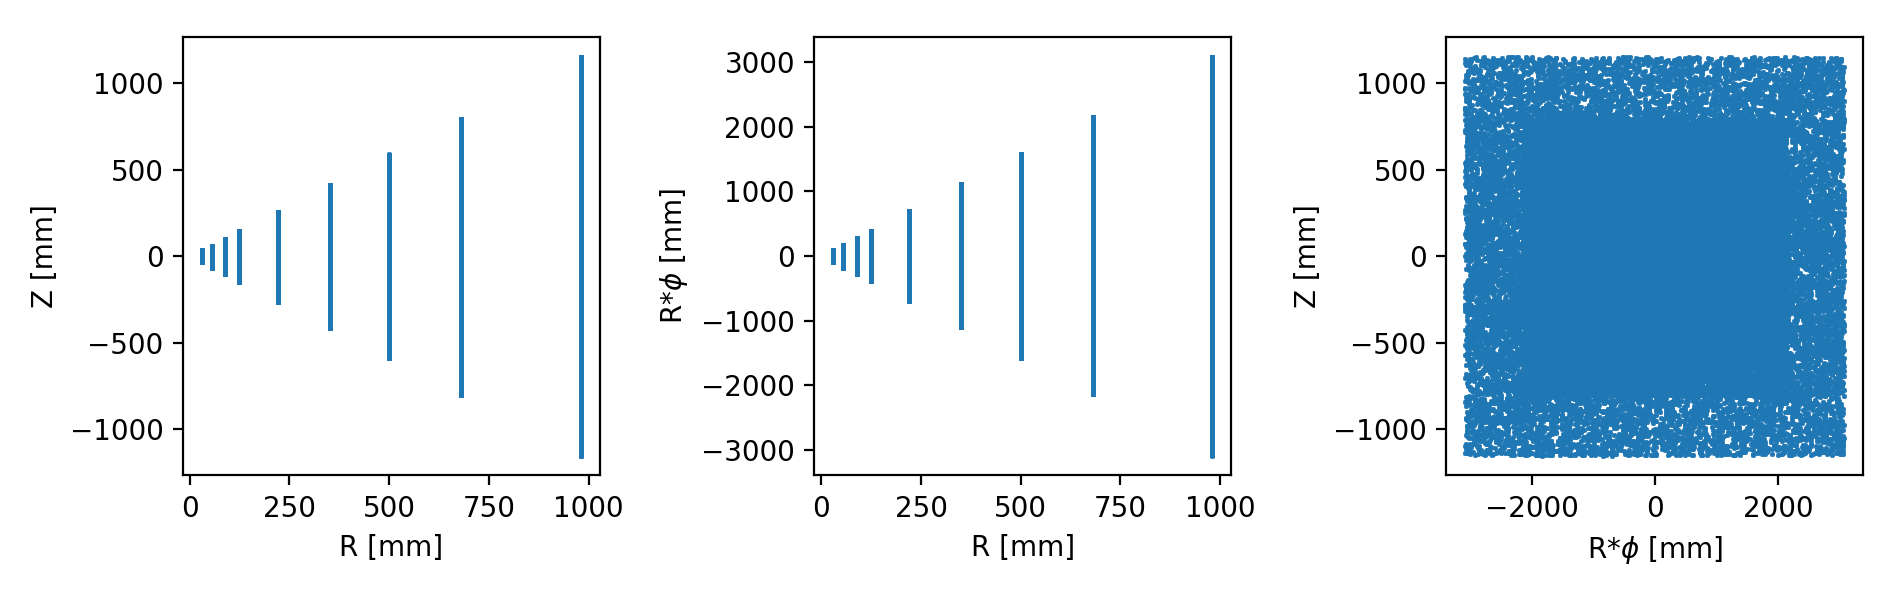

In [9]:
# Plot the distribution of hits
plt.figure(figsize=(9.5,3))
plt.subplot(131)
plt.scatter(data.r.flatten(), data.z.flatten(), s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')

plt.subplot(132)
plt.scatter(data.r.flatten(), data.rphi.flatten(), s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('R*$\phi$ [mm]')

plt.subplot(133)
plt.scatter(data.rphi.flatten(), data.z.flatten(), s=1, marker=',')
plt.xlabel('R*$\phi$ [mm]')
plt.ylabel('Z [mm]')
plt.tight_layout()

<IPython.core.display.Javascript object>


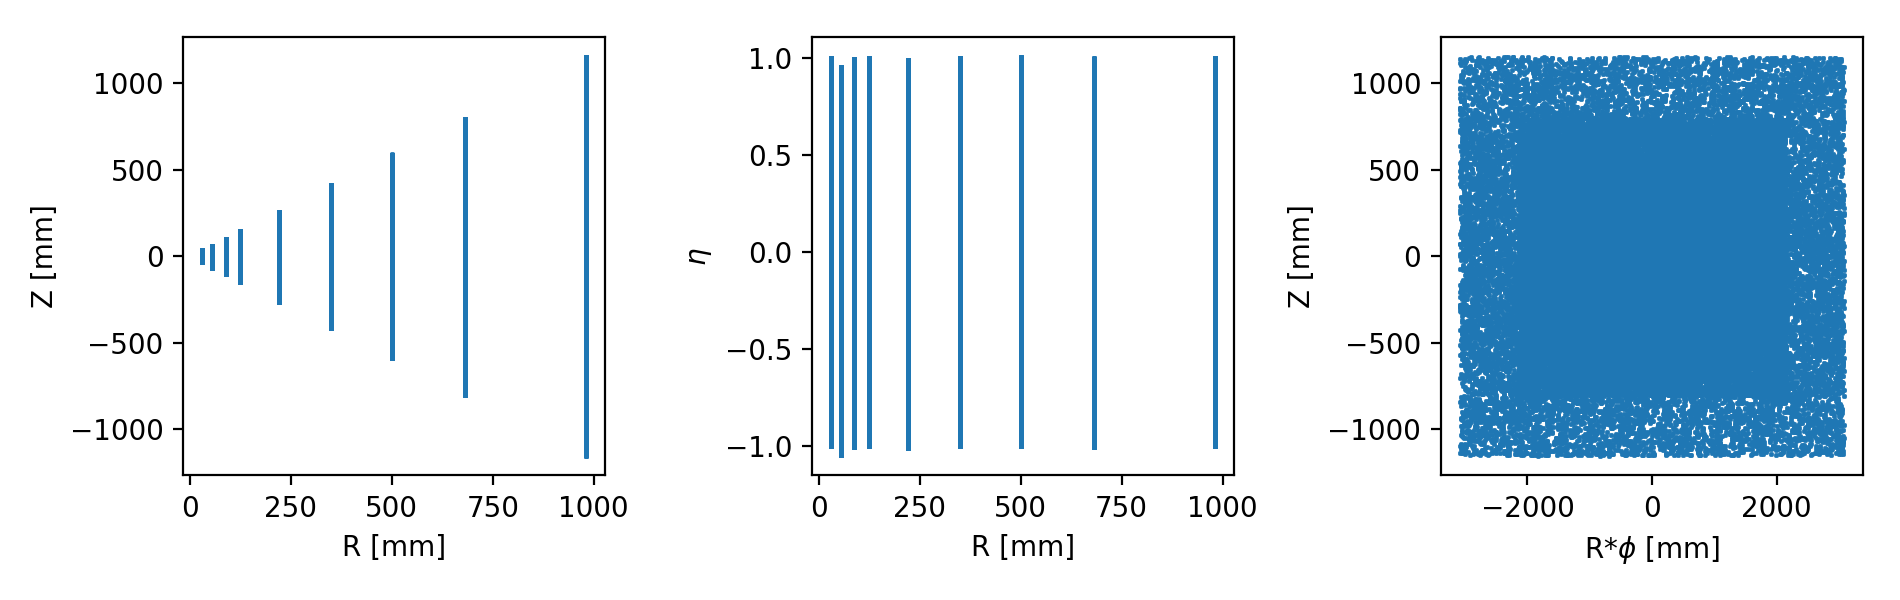

In [10]:
# Plot the distribution of hits
plt.figure(figsize=(9.5,3))
plt.subplot(131)
plt.scatter(data.r.flatten(), data.z.flatten(), s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')

plt.subplot(132)
plt.scatter(data.r.flatten(), data.eta.flatten(), s=1, marker=',')
plt.xlabel('R [mm]')
plt.ylabel('$\eta$')

plt.subplot(133)
plt.scatter(data.rphi.flatten(), data.z.flatten(), s=1, marker=',')
plt.xlabel('R*$\phi$ [mm]')
plt.ylabel('Z [mm]')
plt.tight_layout()

<IPython.core.display.Javascript object>


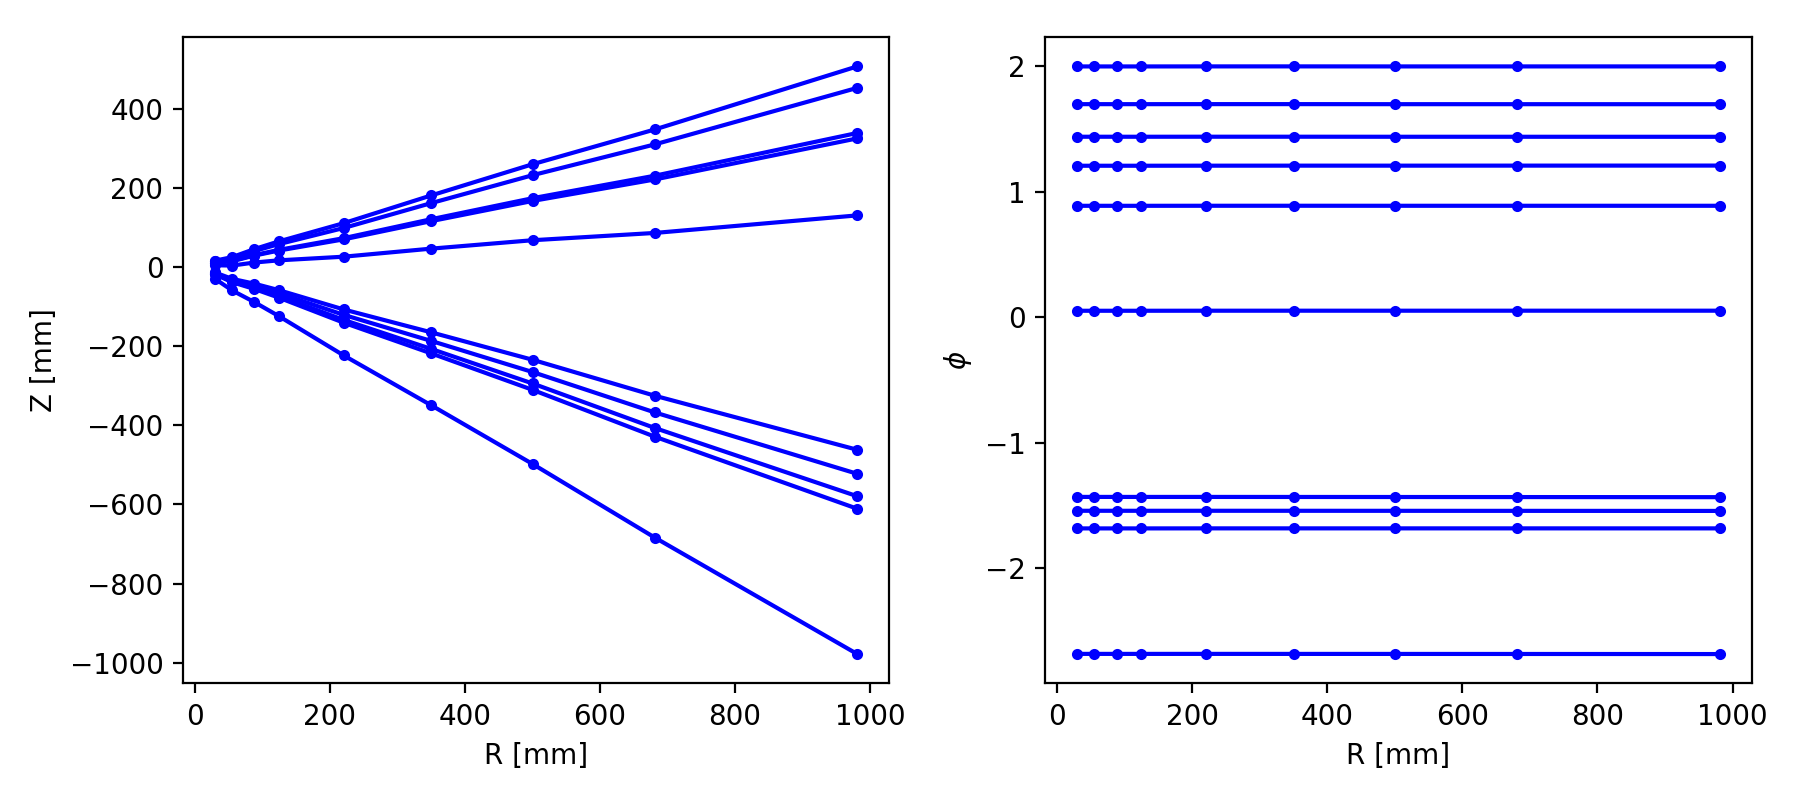

In [11]:
# Draw some tracks in 2D
plt.figure(figsize=(9,4))
num_draw = 10

plt.subplot(121)
for i in range(num_draw):
    plt.plot(data.r[i], data.z[i], 'b.-')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')

plt.subplot(122)
for i in range(num_draw):
    plt.plot(data.r[i], data.phi[i], 'b.-')
plt.xlabel('R [mm]')
plt.ylabel('$\phi$')

plt.tight_layout()

With my shitty phi correction hack, the phi distribution _seems_ well behaved.

<IPython.core.display.Javascript object>


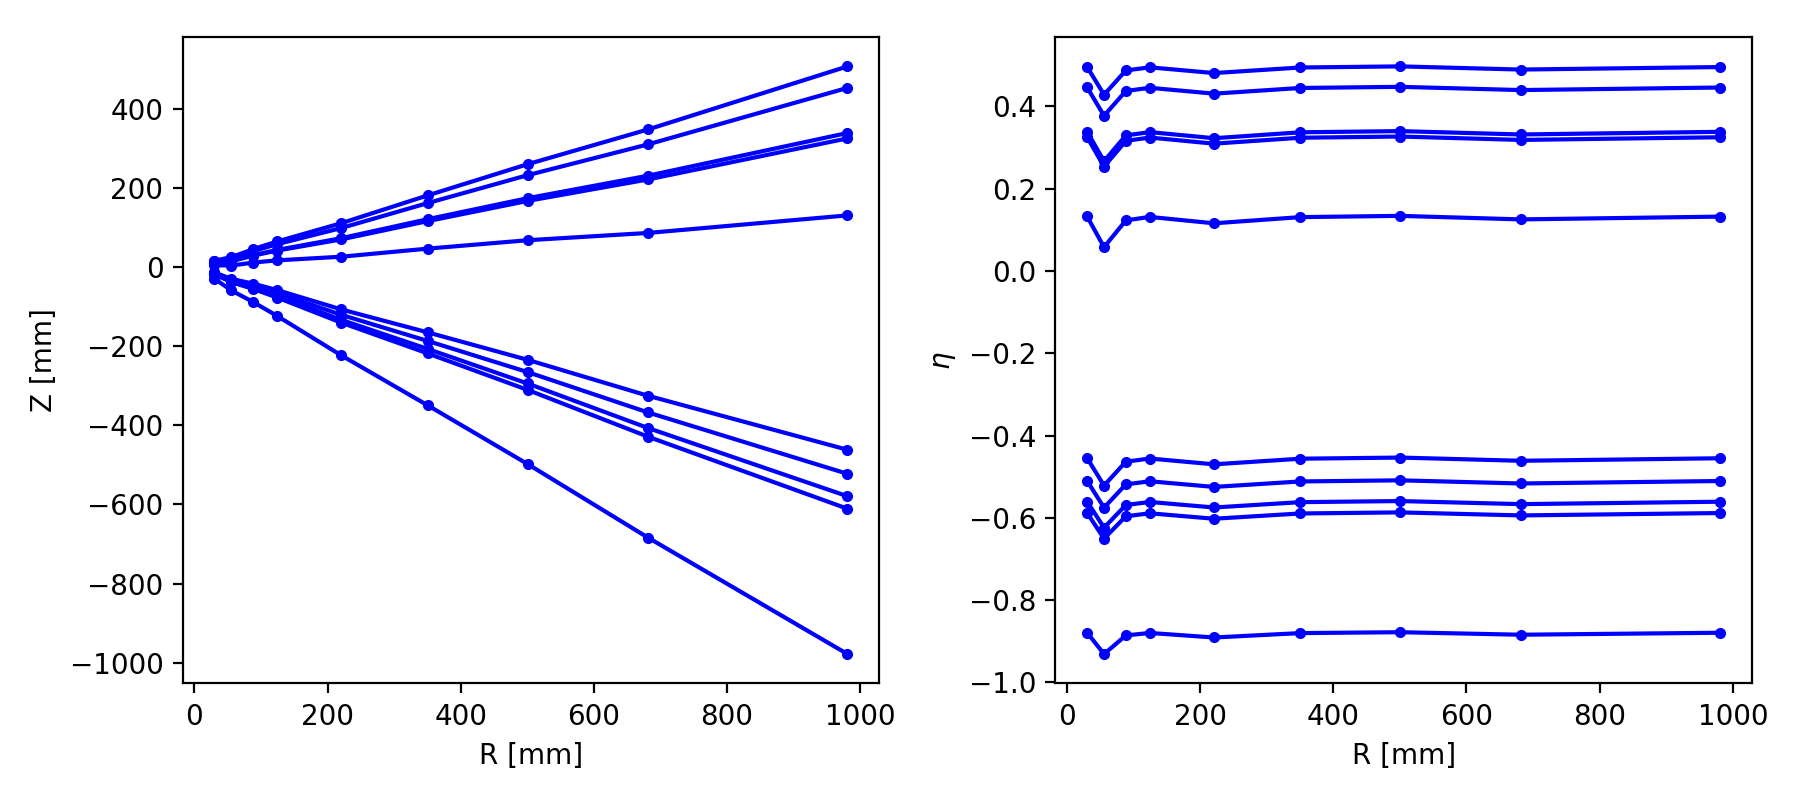

In [12]:
# Draw some tracks in 2D with eta
plt.figure(figsize=(9,4))
num_draw = 10

plt.subplot(121)
for i in range(num_draw):
    plt.plot(data.r[i], data.z[i], 'b.-')
plt.xlabel('R [mm]')
plt.ylabel('Z [mm]')

plt.subplot(122)
for i in range(num_draw):
    plt.plot(data.r[i], data.eta[i], 'b.-')
plt.xlabel('R [mm]')
plt.ylabel('$\eta$')

plt.tight_layout()

Damn, it looks like $\eta$ is messed up, too. Perhaps we should avoid using eta as calculated this way for now.

In [13]:
from lstm_lhc_2d import testrnn

/Users/mudigonda/Tools/anaconda/envs/lhc/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [14]:
from lstm_lhc_2d import TestConfig

In [15]:
TC = TestConfig()
Max_Train_Sample_Idx = 24362
TC.MaxNumSteps = 9
LSTM_LHC = testrnn(TC)

Python 2.7.13 |Continuum Analytics, Inc.| (default, Dec 20 2016, 23:05:08) 
Type "copyright", "credits" or "license" for more information.

IPython 5.3.0 -- An enhanced Interactive Python.
?         -> Introduction and overview of IPython's features.
%quickref -> Quick reference.
help      -> Python's own help system.
object?   -> Details about 'object', use 'object??' for extra details.

In [1]: x_transpose.shape()
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
/Users/mudigonda/Projects/AI-HEP.Trk/rnnlhc/rnnlhc/fitting/lstm_lhc_2d.py in <module>()
----> 1 x_transpose.shape()

AttributeError: 'Tensor' object has no attribute 'shape'

In [2]: print x_transpose.get_shape()
(8, 100, 2)

In [3]: print x_reshape.get_shape()
(800, 2)

In [4]: exit



In [16]:
cost_lst = []
test_data = np.dstack((data.phi[Max_Train_Sample_Idx:],data.z[Max_Train_Sample_Idx:]))
data.r.shape

(24462, 9)

In [17]:
with tf.Session() as sess:
        tf.set_random_seed(1234)
        summary_writer = tf.train.SummaryWriter('Logs/')
        sess.run(tf.initialize_all_variables())
        LSTM_LHC.assign_lr(sess,TC.learning_rate)
        for ii in range(700):                    
            batch_data_idx = np.random.randint(0,Max_Train_Sample_Idx,TC.batch_size)
            #batch_data = np.dstack((data.r[idx],data.phi[idx],data.z[idx]))
            batch_data = np.dstack((data.phi[batch_data_idx],data.z[batch_data_idx]))
            cost,summ = LSTM_LHC.run_model(sess,LSTM_LHC,batch_data,LSTM_LHC.train_op)
            summary_writer.add_summary(summ,ii)
            cost_lst.append(cost)
            if np.mod(ii,100) == 0:
                print("cost is {}".format(cost))
                eval_list =[]
                output_list = []
                output,eucl_l = LSTM_LHC.eval_model(sess,LSTM_LHC,test_data,LSTM_LHC.eval_target,LSTM_LHC.eucl_loss)
                print("Euclidean loss is {}".format(eucl_l))
                output_list.append(output)
       
        



cost is 453532.875
Euclidean loss is [ 26357.727  31047.336]
cost is 364786.34375
Euclidean loss is [ 26357.732  31048.654]
cost is 382508.78125
Euclidean loss is [ 26359.766  31049.795]
cost is 439311.875
Euclidean loss is [ 26359.16   31050.744]
cost is 394951.75
Euclidean loss is [ 26358.48   31051.547]
cost is 444540.09375
Euclidean loss is [ 26358.207  31051.811]
cost is 348684.15625
Euclidean loss is [ 26357.227  31052.117]


In [18]:
print(batch_data.shape)

(100, 9, 2)


In [ ]:
#Adding the third dimension
output = output.transpose(1,0,2)
output = np.dstack()
plt.plot(cost_lst)
plt.title('Cost vs iterations')
plt.savefig('RNN_train_1.png')
print("Saving output dump")
np.savez('../data/rnndump.npy',test=test,output=output,filt_test=filtered_test_data)
print("Making plots")
for ii in np.arange(20):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(test[ii,1:,0],test[ii,1:,1],test[ii,1:,2], 'r*',linewidth=3)
    ax.hold(True)
    ax.plot(test[ii,1:,0],test[ii,1:,1],test[ii,1:,2],'r' )
    ax.plot(output[ii,:,0],output[ii,:,1],output[ii,:,2],'g+',linewidth=3)
    ax.plot(output[ii,:,0],output[ii,:,1],output[ii,:,2],'g')
    ax.hold(True)
    ax.view_init(elev=18, azim=-27)
    ax.dist=9
    plt.savefig('png/3dacts_'+str(ii)+'.png')
    proj_2d_plot(test,output,savestr='proj_lstm_')
    proj_2d_plot(test,filtered_test_data,savestr='proj_kf_')